# Experimentation for creating a dataloader

In [ ]:
from collections.abc import Iterable
from pathlib import Path
from typing import Literal

import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np

## Class implementation

In [ ]:
class TrainingImgLoader:
    """Data loader for loading, enhancing and serving training images. The images are
    stored on the host, and only moved to the JAX devices when a batch is served using
    [`organic.TrainingImgLoader.get_batch`][]."""

    # Required instance attributes.
    arrays: np.ndarray
    zoomf: tuple[float, float] | None
    bkgf: tuple[float, float] | None
    rotate: bool
    fliph: bool
    flipv: bool
    dave: str

    # Class attributes.
    _ALLOWED_READ_MODES: tuple[str, ...] = ("NUMPY",)

    def __init__(
        self,
        files: Iterable[Path | str],
        *,
        zoomf: tuple[float, float] | None = None,
        bkgf: tuple[float, float] | None = None,
        rotate: bool = True,
        fliph: bool = True,
        flipv: bool = True,
        read_mode: Literal["NUMPY"] = "NUMPY",
    ) -> None:
        """**Arguments**

        - `files`: Sequence of filepaths to images stored on disk.
        - `zoomf`: Range of factor to randomly zoom the images in by. Negative factors
            correspond to zooming out, postive factors to zooming in.
        - `bkgf`: Range of factor of contribution for an additional background flux
            component. If set, an additional uniform flux level will be added to each
            pixel, such that the sum of this additional component accounts for
            `bkgf * 100` percent of the total final image flux.
        - `rotate`: Randomly rotate input images.
        - `fliph`: Randomly flip images horizontally.
        - `flipv`: Randomly flip images vertically.
        - `read_mode`: How to interpret image files stored on disk. E.g. `NUMPY` to read
            serialized Numpy arrays in .npy files.
        """
        # Direct initialisation.
        self.zoomf = zoomf
        self.bkgf = bkgf
        self.rotate = rotate
        self.fliph, self.flipv = fliph, flipv

        # Validate read mode
        if read_mode not in self._ALLOWED_READ_MODES:
            raise ValueError(
                f"Read method {read_mode} is not supported."
                f"Supported options are: {', '.join(self._ALLOWED_READ_MODES)}"
            )

        # Reading in arrays (3D array shape ->  (Y, X, Channel) index ordering).
        files = [Path(file) for file in files]  #  Cast to Path if needed.
        img_list = []
        img_shape = None
        for file in files:
            img = self._read_img(file, read_mode)
            img_list.append(img)
            if (np.shape(img) != img_shape) and (img_shape is not None):
                raise ValueError(
                    f"Inconsistent shape of the current image: {np.shape(img)}."
                    f"The previous image's shape is: {img_shape}."
                )
            else:
                img_shape = np.shape(img)

        # Assign arrays (4D array -> (Batch, Y, X, Channel) index ordering).
        # Note that these are still stored on the host. Move to JAX device is per batch.
        self.arrays = np.stack(img_list, axis=0)

    @staticmethod
    def _read_img(file: Path, read_mode: str) -> np.ndarray:
        """Master method to load in an image from a file stored on disk. The array
        should have a 3D shape, with (Y, X, Channel) index ordering."""
        if read_mode == "NUMPY":
            img = TrainingImgLoader._read_img_numpy(file)
        else:
            raise ValueError(f"Read mode {read_mode} is not supported.")
        if img.ndim != 3:
            raise ValueError(
                "Loaded images should have 3D shape (index ordering -> Y, X, Channel)."
                f"Instead found number of dimensions {img.ndim} for file {file}."
            )
        return img

    @staticmethod
    def _read_img_numpy(file: Path) -> np.ndarray:
        """Read in a numpy image array stored on disk."""
        img = None
        with open(file, "rb") as f:
            img = np.load(f)
        return img

    def _enhance_batch(self, img_batch: np.ndarray, normalize: bool) -> np.ndarray:
        """Enhance a batch of images, passed along as a 4D numpy array (index ordering
        -> Batch, Y, X, Channel)."""
        raise NotImplementedError

    # load
    def get_batch(
        self, batch_size: int, *, key: jax.Array, normalize: bool = True
    ) -> Iterable[jax.Array]:
        """Returns a batch of images as a JAX array.

        **Arguments:**

        - `batch_size`: Size of the batch.
        - `key`: A JAX PRNG key, used to randomly permute the set of training data
            each training epoch.
        - `normalize`: Whether or not to normalize the images. If `True`, each image
            is normalized to the numerical range [-1, 1], where -1 , 0 an 1 respectively
            denote the minimum, halfway point and maximum of the intensity in the
            original image.

        **Returns:**

        A generator yielding 4D JAX arrays containing the images, using (Batch, Y, X,
        Channel) index ordering. The batched images are enhanced according to the
        various attributes set in the `TrainingImgLoader` instance.
        """
        dataset_size = self.arrays.shape[0]

        # Keep continuously feeding epochs.
        idxs = jnp.arange(dataset_size)
        while True:
            key, perm_key = jr.split(key, 2)
            perm_idxs = jr.permutation(perm_key, idxs)  # Permute dataset indices.

            # Loop over batches in single epoch.
            start = 0
            end = batch_size
            while end < dataset_size:
                batch_idxs = perm_idxs[start:end]  # Image indices for current batch.
                img_batch = np.copy(self.arrays[batch_idxs])  # Make a deep copy.
                img_batch = self._enhance_batch(img_batch, normalize)

                yield jnp.array(img_batch)

                start = end  # Set state for next batch.
                end = start + batch_size

## Example

In [55]:
directory = """/home/toond/Documents/phd/paper_matisse_imaging/training_data/\
discs_mcfost/runs/ozstar_2zone_cont_training_set/saved_imgs"""

files = sorted(Path(directory).glob("*.npy"))

loader = TrainingImgLoader(
    files,
    zoomf=(-0.1, 0.1),
    bkgf=(0.00, 0.20),  ## Example
    rotate=True,
    fliph=True,
    flipv=True,
    read_mode="NUMPY",
)

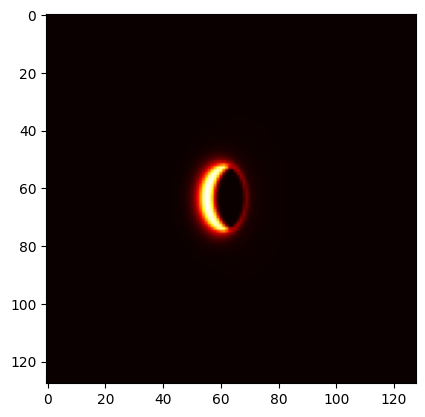

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.imshow(loader.arrays[103, :, :, :], cmap="hot")

In [58]:
files_alt = [
    "/home/toond/Documents/phd/paper_matisse_imaging/training_data/discs_mcfost/runs/ozstar_2zone_cont_training_set/saved_imgs/model_wave_1.7532333182807696_inc_22.64322.npy",
    "/home/toond/Documents/phd/paper_matisse_imaging/training_data/discs_mcfost/runs/ozstar_2zone_cont_training_set/saved_imgs/model_wave_1.731110214837802_inc_46.29298.npy",
]

loader_alt = TrainingImgLoader(
    files_alt,
    zoomf=(-0.1, 0.1),
    bkgf=(0.00, 0.20),  ## Example
    rotate=True,
    fliph=True,
    flipv=True,
    read_mode="NUMPY",
)

In [59]:
np.shape(loader_alt.arrays)

(2, 128, 128, 1)